
Loaded samples:
- Training: 10,901
- Test:     2,698

Final dataset sizes:
- Training:   8,720
- Validation: 2,181
- Test:       2,698


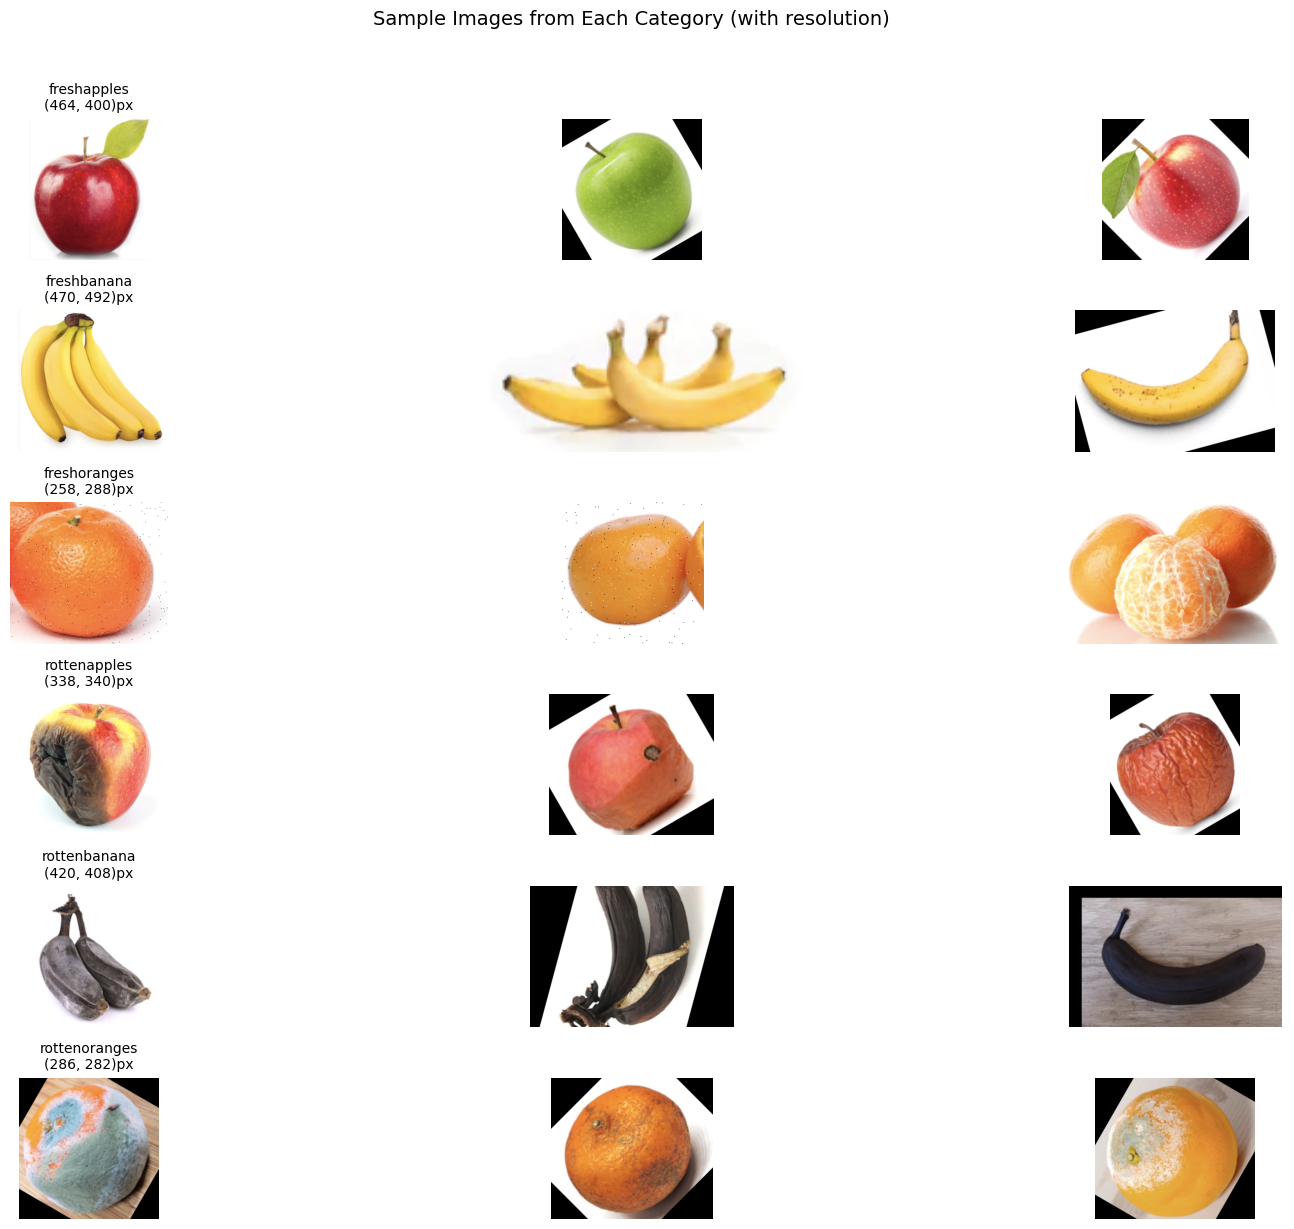

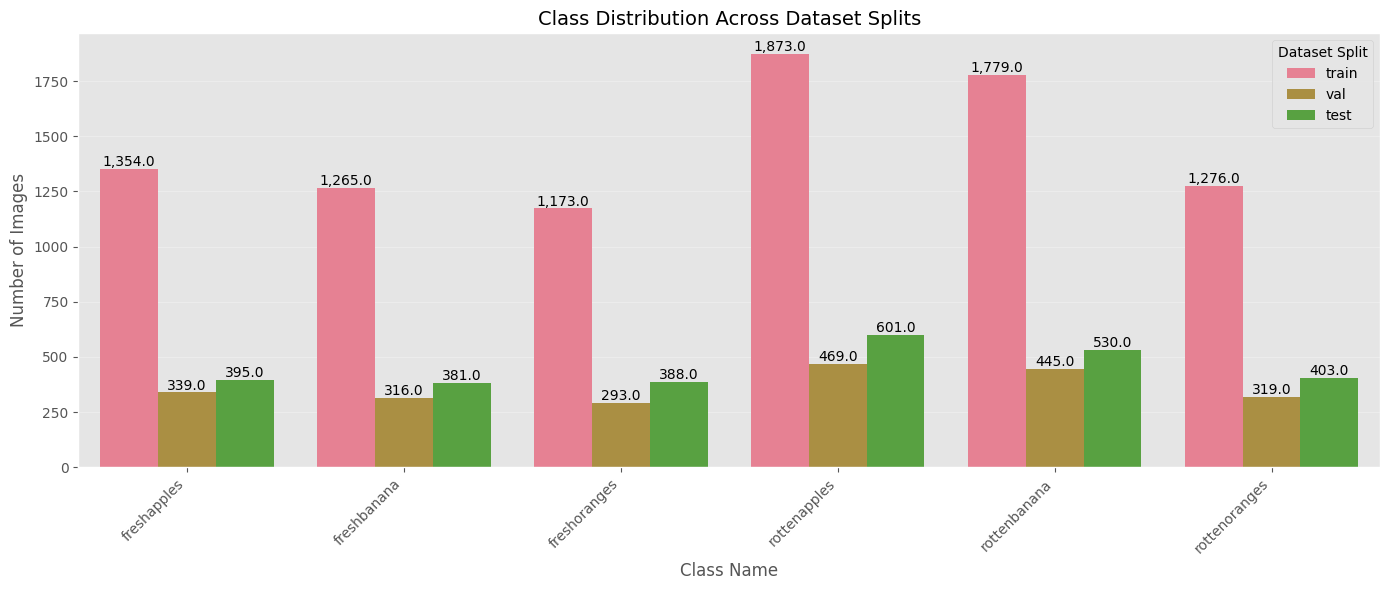


Class Distribution Summary:
split          test  train   val    All
label                                  
freshapples     395   1354   339   2088
freshbanana     381   1265   316   1962
freshoranges    388   1173   293   1854
rottenapples    601   1873   469   2943
rottenbanana    530   1779   445   2754
rottenoranges   403   1276   319   1998
All            2698   8720  2181  13599


In [1]:
# --------------------------
# Data Loading & Preparation
# --------------------------
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split

# Set style for plots
plt.style.use('ggplot')
sns.set_palette("husl")

# Verify dataset path exists
dataset_path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset'
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset directory not found at {dataset_path}")

train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

# Verify train/test directories exist
for path in [train_dir, test_dir]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Directory not found: {path}")

categories = ['freshapples', 'freshbanana', 'freshoranges',
              'rottenapples', 'rottenbanana', 'rottenoranges']

def load_data(directory):
    """Load image data with enhanced error handling and validation"""
    files, labels = [], []
    for category in categories:
        category_path = os.path.join(directory, category)
        if not os.path.exists(category_path):
            raise FileNotFoundError(f"Category directory missing: {category_path}")
            
        # Get valid image files
        valid_extensions = ('.png', '.jpg', '.jpeg')
        images = [f for f in os.listdir(category_path) 
                 if f.lower().endswith(valid_extensions)]
        
        if not images:
            raise ValueError(f"No valid images found in {category_path}")
            
        # Store metadata
        for img in images:
            img_path = os.path.join(category_path, img)
            if not os.path.isfile(img_path):
                print(f"Warning: Missing file {img_path}")
                continue
            files.append(img_path)
            labels.append(category)
    
    if not files:
        raise ValueError(f"No valid images found in {directory}")
        
    return pd.DataFrame({'filename': files, 'label': labels})

# Load data with validation
try:
    df_train = load_data(train_dir)
    df_test = load_data(test_dir)
except Exception as e:
    print(f"Data loading failed: {str(e)}")
    raise

print(f"\nLoaded samples:")
print(f"- Training: {len(df_train):,}")
print(f"- Test:     {len(df_test):,}")

# Train-validation split
try:
    train_df, val_df = train_test_split(
        df_train,
        test_size=0.2,
        stratify=df_train['label'],
        random_state=42
    )
except ValueError as e:
    print(f"Split failed: {str(e)}")
    raise

print(f"\nFinal dataset sizes:")
print(f"- Training:   {len(train_df):,}")
print(f"- Validation: {len(val_df):,}")
print(f"- Test:       {len(df_test):,}")

# --------------------------
# Enhanced Visualizations
# --------------------------

# 1. Sample Images Grid
plt.figure(figsize=(18, 12))
for idx, category in enumerate(categories):
    # Get 3 samples per category
    samples = train_df[train_df['label'] == category].sample(3, random_state=42)
    
    for j, (_, row) in enumerate(samples.iterrows()):
        ax = plt.subplot(6, 3, idx*3 + j + 1)  # 6 rows, 3 columns
        
        try:
            img = cv2.imread(row['filename'])
            if img is None:
                raise FileNotFoundError("Empty file")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            plt.imshow(img)
            plt.axis('off')
            if j == 0:
                plt.title(f"{category}\n{img.shape[:2]}px", fontsize=10)
        except Exception as e:
            plt.imshow(np.zeros((100, 100, 3)))
            plt.title(f"Error loading\n{os.path.basename(row['filename'])}", color='red', fontsize=8)
            plt.axis('off')

plt.suptitle("Sample Images from Each Category (with resolution)", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

# 2. Class Distribution Analysis
# Prepare data
dist_data = pd.concat([
    train_df['label'].rename('train'),
    val_df['label'].rename('val'),
    df_test['label'].rename('test')
], axis=1)

# Melt for seaborn
dist_melt = dist_data.melt(var_name='split', value_name='label')

plt.figure(figsize=(14, 6))
ax = sns.countplot(
    data=dist_melt,
    x='label',
    hue='split',
    order=categories
)

# Add annotations
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():,}", 
        (p.get_x() + p.get_width()/2., p.get_height()),
        ha='center', va='center', 
        xytext=(0, 5), 
        textcoords='offset points'
    )

plt.title("Class Distribution Across Dataset Splits", fontsize=14)
plt.xlabel("Class Name", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset Split')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Class Balance Table
print("\nClass Distribution Summary:")
print(pd.crosstab(dist_melt['label'], dist_melt['split'], margins=True))

In [2]:
# ----------------------
# Data Augmentation
# ----------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TARGET_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='constant',
    cval=0.0  # Fill empty areas with black
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators with explicit class list
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=TARGET_SIZE,
    class_mode='sparse',
    classes=categories,
    batch_size=64,  # Increased batch size for better performance
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='label',
    target_size=TARGET_SIZE,
    class_mode='sparse',
    classes=categories,
    batch_size=64,
    shuffle=False
)

Found 8720 validated image filenames belonging to 6 classes.
Found 2181 validated image filenames belonging to 6 classes.


In [3]:
# ----------------------
# Model Architecture
# ----------------------
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Base model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model initially
base_model.trainable = False

# Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
outputs = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,769,670 (94.49 MB)

 Trainable params: 1,181,958 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [4]:
# ----------------------
# Model Training
# ----------------------
from sklearn.utils.class_weight import compute_class_weight

# Get class weights
classes = np.unique(train_generator.classes)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_generator.classes
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Update ModelCheckpoint to use .keras extension
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
    ModelCheckpoint('best_model_resnet.keras',  # Changed extension to .keras
                    monitor='val_accuracy', 
                    save_best_only=True)
]

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# ----------------------
# Fine-Tuning
# ----------------------
# When loading the model later, use:
# model = tf.keras.models.load_model('best_model_resnet.keras')

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


137/137 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.1897 - loss: 2.9129 - val_accuracy: 0.2549 - val_loss: 2.3903 - learning_rate: 1.0000e-04
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self

137/137 ━━━━━━━━━━━━━━━━━━━━ 142s 990ms/step - accuracy: 0.2556 - loss: 2.3659 - val_accuracy: 0.3654 - val_loss: 2.0417 - learning_rate: 1.0000e-04
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 126us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 141s 982ms/step - accuracy: 0.3046 - loss: 2.0758 - val_accuracy: 0.3599 - val_loss: 1.8953 - learning_rate: 1.0000e-04
Epoch 6/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 116us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 142s 987ms/step - accuracy: 0.3275 - loss: 1.9261 - val_accuracy: 0.3659 - val_loss: 1.8021 - learning_rate: 1.0000e-04
Epoch 8/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 122us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 9/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 142s 985ms/step - accuracy: 0.3519 - loss: 1.8500 - val_accuracy: 0.3847 - val_loss: 1.7569 - learning_rate: 1.0000e-04

In [5]:
# ----------------------
# Fine-Tuning
# ----------------------
# Update 1: Change checkpoint filename extension
best_checkpoint = 'best_model_resnet.keras'

# Update 2: Add epoch printing callback
from tensorflow.keras.callbacks import LambdaCallback

epoch_print_callback = LambdaCallback(
    on_epoch_begin=lambda epoch, logs: print(f"\nStarting Epoch {epoch+1}/{history.params['epochs']}")
)

# Update callback list
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
    ModelCheckpoint(best_checkpoint, monitor='val_accuracy', save_best_only=True),
    epoch_print_callback  # Add epoch tracking
]

# Unfreeze deeper layers
base_model.trainable = True
for layer in base_model.layers[:140]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning phase
history_fine = model.fit(
    train_generator,
    initial_epoch=history.epoch[-1] + 1,
    epochs=60,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Update 3: Load model with correct extension
from tensorflow.keras.models import load_model
model = load_model(best_checkpoint)  # Changed from load_weights to load_model


Starting Epoch 31/30
Epoch 31/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 143s 999ms/step - accuracy: 0.5127 - loss: 1.3862 - val_accuracy: 0.4053 - val_loss: 1.5583 - learning_rate: 1.0000e-05

Starting Epoch 33/30
Epoch 33/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 143s 991ms/step - accuracy: 0.5532 - loss: 1.2780 - val_accuracy: 0.5094 - val_loss: 1.3656 - learning_rate: 1.0000e-05

Starting Epoch 34/30
Epoch 34/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 144s 999ms/step - accuracy: 0.5744 - loss: 1.1954 - val_accuracy: 0.5704 - val_loss: 1.2217 - learning_rate: 1.0000e-05

Starting Epoch 35/30
Epoch 35/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.6010 - loss: 1.1484 - val_accuracy: 0.6525 - val_loss: 1.0220 - learning_rate: 1.0000e-05

Starting Epoch 36/30
Epoch 36/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 142s 986ms/step - accuracy: 0.6284 - loss: 1.0748 - val_accuracy: 0.6520 - val_loss: 1.0760 - learning_rate: 1.0000e-05

Starting Epoch 37/30
Epoch 37/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 143s 998ms/step - accurac

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


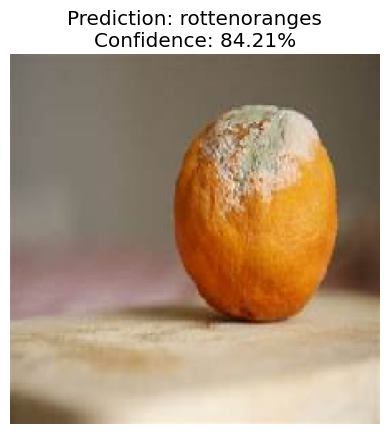


Test prediction: ('rottenoranges', 84.21)


In [6]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Kaggle-specific paths
MODEL_PATH = '/kaggle/working/best_model_resnet.keras'  # Default Kaggle working directory

def kaggle_predict(image_path, show_image=True):
    """
    Kaggle-optimized prediction function
    
    Args:
        image_path (str): Path relative to Kaggle input directory
        show_image (bool): Whether to display the image
    
    Returns:
        tuple: (predicted_class, confidence)
    """
    # Load model (cached after first load)
    try:
        model = load_model(MODEL_PATH)
    except:
        raise ValueError("Model not found. Train first or check path!")
    
    # Full path for Kaggle input
    full_path = f'{image_path}'
    
    # Load and preprocess image
    try:
        img = image.load_img(full_path, target_size=(224, 224))
    except Exception as e:
        raise ValueError(f"Error loading {full_path}: {str(e)}")
    
    # Preprocess and predict
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    predictions = model.predict(img_array)
    predicted_idx = np.argmax(predictions[0])
    confidence = np.max(predictions[0]) * 100
    predicted_class = categories[predicted_idx]
    
    # Show results
    if show_image:
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence:.2f}%")
        plt.show()
    
    return predicted_class, round(confidence, 2)

# Example usage:
# 1. Upload your image to Kaggle (via Add Data button or notebook upload)
# 2. Use path like 'your-filename.jpg' if in main directory
#    or 'your-dataset-name/your-image.jpg' if added via dataset

# Try with a test image from the dataset first to verify
test_prediction = kaggle_predict("/kaggle/input/rotten/rotten.jpg")
print("\nTest prediction:", test_prediction)

# For your own image (uploaded via Kaggle's UI):
# your_prediction = kaggle_predict("your-uploaded-image.jpg")

Found 2698 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 706ms/step
📊 Comprehensive Classification Report:

🔍 Enhanced Classification Report:
               precision    recall  f1-score  specificity     support
freshapples     0.859008  0.832911  0.845758     0.976552   395.00000
freshbanana     0.943878  0.971129  0.957309     0.990505   381.00000
freshoranges    0.842723  0.925258  0.882064     0.970996   388.00000
rottenapples    0.859833  0.683860  0.761816     0.968050   601.00000
rottenbanana    0.944144  0.988679  0.965899     0.985701   530.00000
rottenoranges   0.752155  0.866005  0.805075     0.949891   403.00000
accuracy        0.868050  0.868050  0.868050          NaN     0.86805
macro avg       0.866957  0.877974  0.869654          NaN  2698.00000
weighted avg    0.869598  0.868050  0.865557          NaN  2698.00000


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


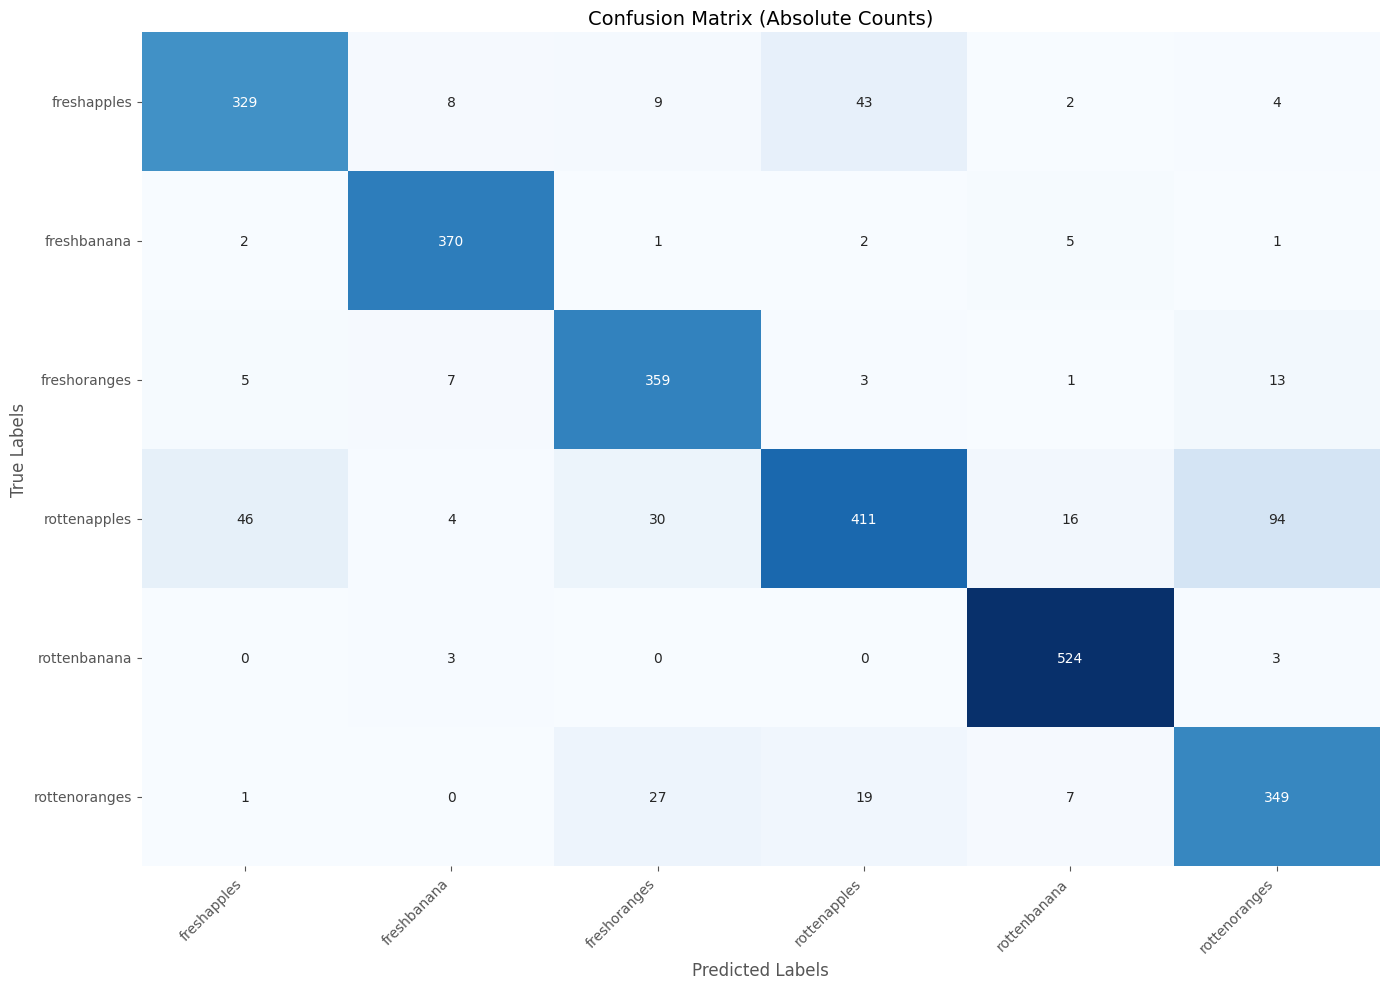

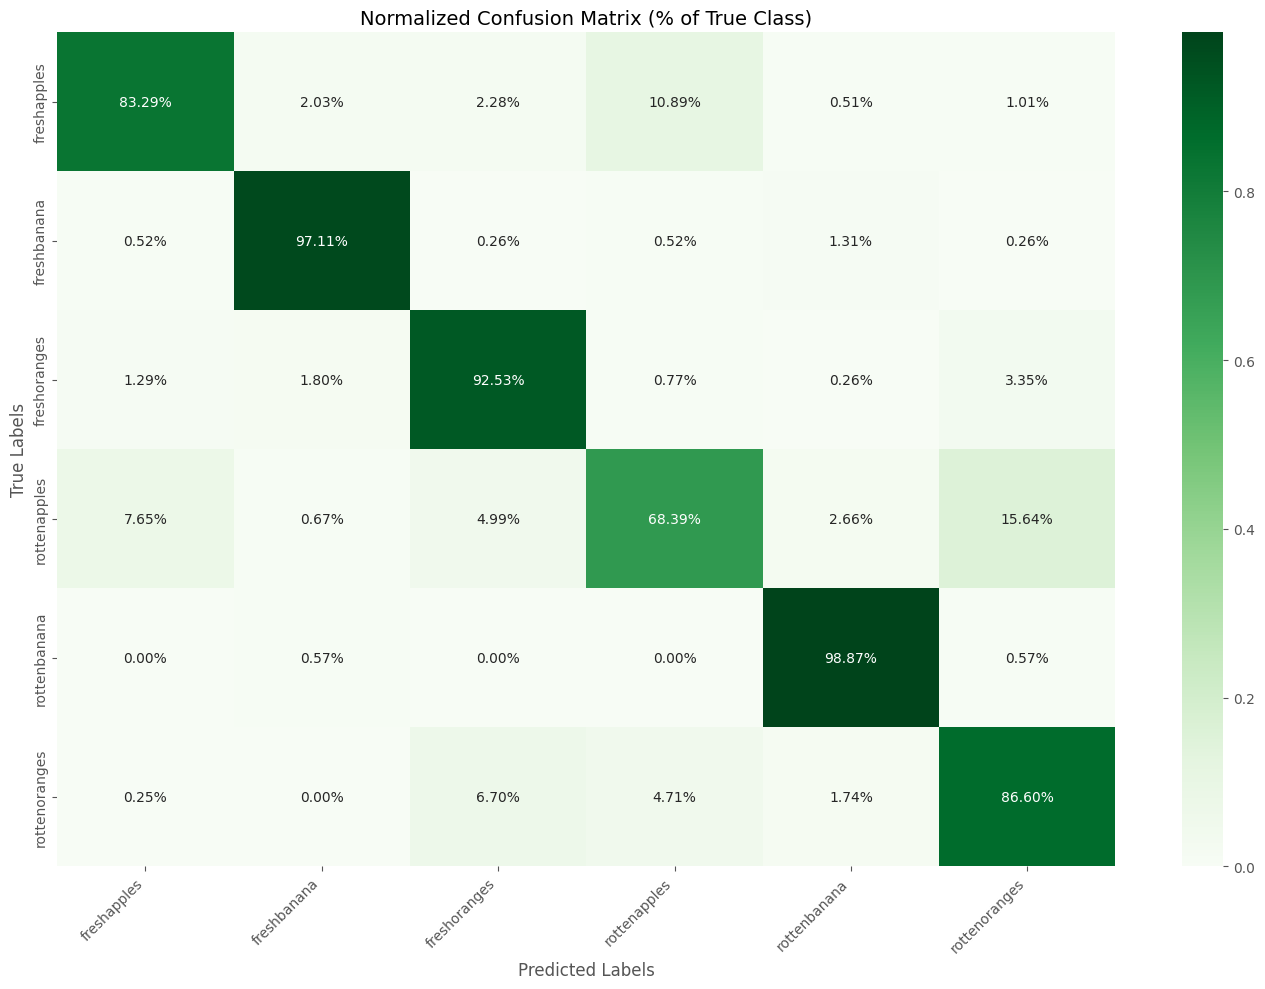

In [7]:
# --------------------------
# Evaluation Metrics (Corrected)
# --------------------------
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load best model
model = load_model('/kaggle/working/best_model_resnet.keras')

# Prepare test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='filename',
    y_col='label',
    target_size=TARGET_SIZE,
    class_mode='sparse',
    classes=categories,
    batch_size=64,
    shuffle=False
)

# Get predictions
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Classification Report
print("📊 Comprehensive Classification Report:")
clf_report = classification_report(
    y_true,
    y_pred,
    target_names=categories,
    digits=4,
    output_dict=True
)

# Calculate specificity
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    spec = []
    for i in range(len(categories)):
        tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
        fp = cm[:,i].sum() - cm[i,i]
        spec.append(tn / (tn + fp))
    return spec

# Create class-specific metrics dataframe
class_report = pd.DataFrame(clf_report).transpose()
specificities = specificity_score(y_true, y_pred)

# Add specificity to class rows only
class_report['specificity'] = np.nan
for i, cat in enumerate(categories):
    class_report.loc[cat, 'specificity'] = specificities[i]

print("\n🔍 Enhanced Classification Report:")
print(class_report[['precision', 'recall', 'f1-score', 'specificity', 'support']])

# Confusion Matrix (Absolute Values)
plt.figure(figsize=(14, 10))
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=categories,
    yticklabels=categories,
    cbar=False
)

plt.title('Confusion Matrix (Absolute Counts)', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Normalized Confusion Matrix
plt.figure(figsize=(14, 10))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2%',
    cmap='Greens',
    xticklabels=categories,
    yticklabels=categories
)

plt.title('Normalized Confusion Matrix (% of True Class)', fontsize=14)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [9]:
# ----------------------
# Core Dependencies
# ----------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow Components
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.efficientnet import preprocess_input

# Visual Setup
plt.style.use('ggplot')
sns.set_palette("husl")


In [11]:
# ----------------------
# Path Configuration
# ----------------------
dataset_path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset'
categories = ['freshapples', 'freshbanana', 'freshoranges',
              'rottenapples', 'rottenbanana', 'rottenoranges']

# Verify paths
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

In [12]:
# ----------------------
# DataFrame Creation
# ----------------------
def create_dataframe(directory):
    image_paths = []
    labels = []
    
    for category in categories:
        cat_path = os.path.join(directory, category)
        for img_name in os.listdir(cat_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(cat_path, img_name))
                labels.append(category)
    
    return pd.DataFrame({
        'image_path': image_paths,
        'category': labels
    })

# Load data
train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

In [14]:
# ----------------------
# Train-Validation Split
# ----------------------
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['category'],
    random_state=42
)

In [15]:
# ----------------------
# EfficientNet Generators
# ----------------------
BATCH_SIZE = 64
TARGET_SIZE = (224, 224)

# Create generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='category',
    target_size=TARGET_SIZE,
    class_mode='sparse',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='category',
    target_size=TARGET_SIZE,
    class_mode='sparse',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 6976 validated image filenames belonging to 6 classes.
Found 1744 validated image filenames belonging to 6 classes.


In [22]:
def build_model():
    # Base model with proper parenthesis
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)  # Added closing parenthesis
    )  # Added closing parenthesis for the base model
    
    # Freezing layers
    for layer in base_model.layers:
        layer.trainable = False
        if isinstance(layer, BatchNormalization):
            layer.trainable = True
    
    # Custom head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(len(categories), activation='softmax')(x)
    
    return Model(inputs=base_model.input, outputs=outputs)

model = build_model()

In [23]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True
    )
]

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Initial training
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

# Fine-tuning preparation
for layer in model.layers[-20:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    initial_epoch=history.epoch[-1] + 1,
    epochs=60,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


109/109 ━━━━━━━━━━━━━━━━━━━━ 135s 677ms/step - accuracy: 0.3514 - loss: 2.8664 - val_accuracy: 0.8773 - val_loss: 1.7744 - learning_rate: 1.0000e-04
Epoch 2/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 58s 505ms/step - accuracy: 0.8073 - loss: 1.6367 - val_accuracy: 0.9593 - val_loss: 1.2759 - learning_rate: 1.0000e-04
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 57s 498ms/step - accuracy: 0.8936 - loss: 1.3991 - val_accuracy: 0.9765 - val_loss: 1.1604 - learning_rate: 1.0000e-04
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 58s 502ms/step - accuracy: 0.9210 - loss: 1.2937 - val_accuracy: 0.9839 - val_loss: 1.1155 - learning_rate: 1.0000e-04
Epoch 5/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 58s 502ms/step - accuracy: 0.9465 - loss: 1.2145 - val_accuracy: 0.9868 - val_loss: 1.0820 - learning_rate: 1.0000e-04
Epoch 6/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 58s 508ms/step - accuracy: 0.9492 - loss: 1.1750 - val_accuracy: 0.9880 - val_loss: 1.0571 - learning_rate: 1.0000e-04
Epoch 7/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 60s 522ms/step -

Found 2698 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 30s 562ms/step
               precision    recall  f1-score   support

  freshapples     0.3426    0.9646    0.5056       395
  freshbanana     0.8610    0.5853    0.6969       381
 freshoranges     0.7399    0.6160    0.6723       388
 rottenapples     0.8023    0.4592    0.5841       601
 rottenbanana     0.8872    0.5491    0.6783       530
rottenoranges     0.7048    0.5806    0.6367       403

     accuracy                         0.6093      2698
    macro avg     0.7230    0.6258    0.6290      2698
 weighted avg     0.7364    0.6093    0.6276      2698



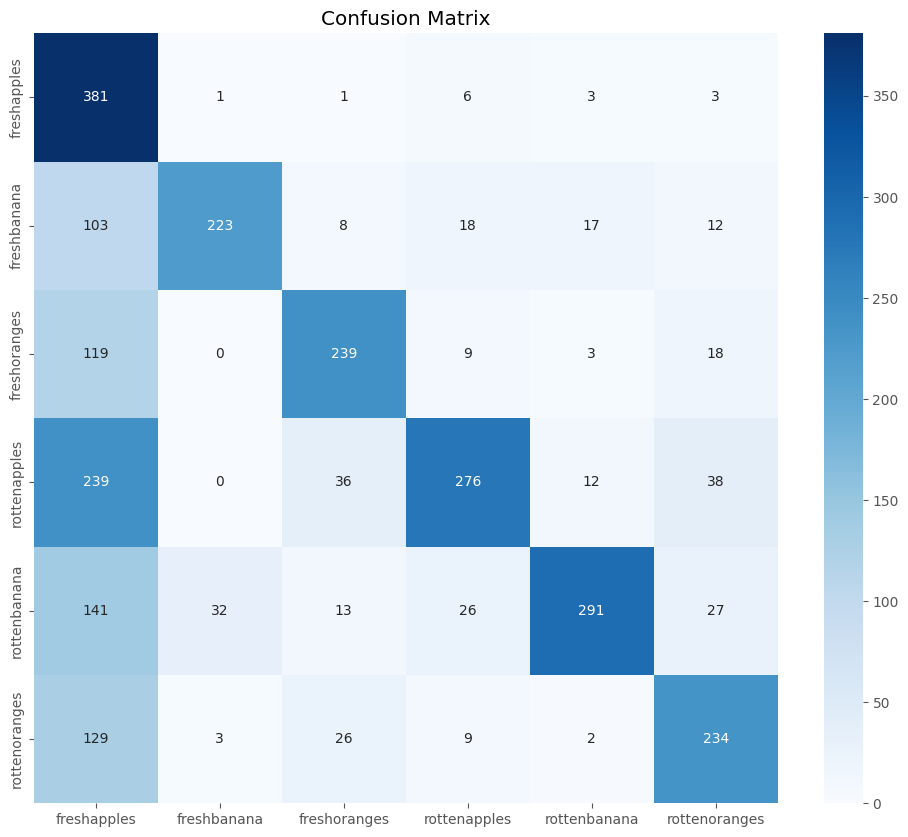

In [25]:
# Load best model
model = load_model('best_model.keras')

# Test generator
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='category',
    target_size=(224, 224),
    class_mode='sparse',
    classes=categories,
    batch_size=64,
    shuffle=False
)

# Predictions
y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# Metrics
print(classification_report(
    y_true,
    y_pred,
    target_names=categories,
    digits=4
))

# Confusion matrix
plt.figure(figsize=(12,10))
sns.heatmap(
    confusion_matrix(y_true, y_pred),
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=categories,
    yticklabels=categories
)
plt.title('Confusion Matrix')
plt.show()

43/43 ━━━━━━━━━━━━━━━━━━━━ 28s 539ms/step
               precision    recall  f1-score   support

  freshapples       0.34      0.96      0.51       395
  freshbanana       0.86      0.59      0.70       381
 freshoranges       0.74      0.62      0.67       388
 rottenapples       0.80      0.46      0.58       601
 rottenbanana       0.89      0.55      0.68       530
rottenoranges       0.70      0.58      0.64       403

     accuracy                           0.61      2698
    macro avg       0.72      0.63      0.63      2698
 weighted avg       0.74      0.61      0.63      2698



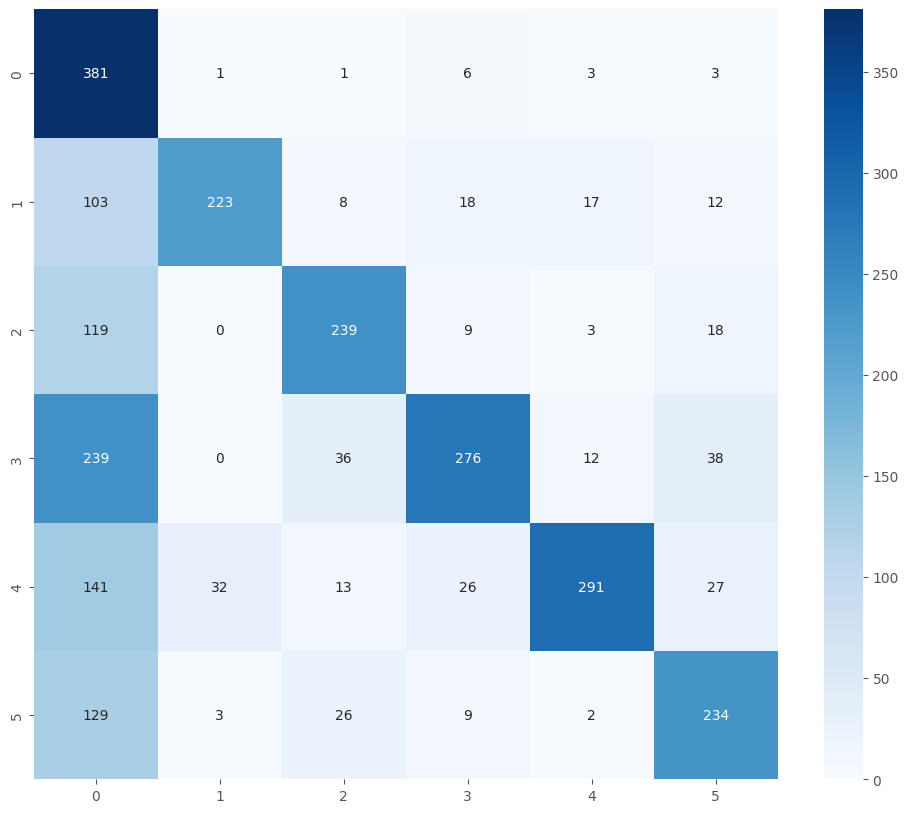

In [26]:
# ----------------------
# Performance Analysis
# ----------------------
model = load_model('best_model.keras')

# Generate predictions
y_pred = np.argmax(model.predict(test_gen), axis=1)
y_true = test_gen.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=categories))

# Confusion matrix
plt.figure(figsize=(12,10))
sns.heatmap(confusion_matrix(y_true, y_pred), 
            annot=True, fmt='d', cmap='Blues')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


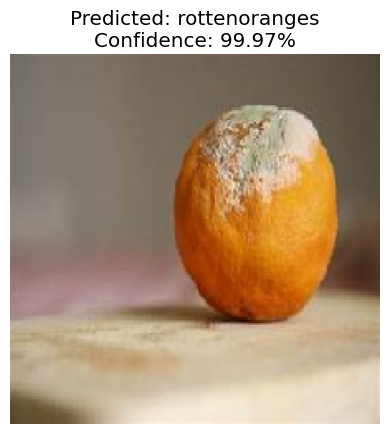

Prediction: rottenoranges (99.97% confidence)


In [27]:
def predict_fruit(image_path):
    """Predict fruit freshness from image path"""
    try:
        # Load and preprocess image
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)
        
        # Make prediction
        preds = model.predict(img_array)
        pred_class = categories[np.argmax(preds)]
        confidence = np.max(preds) * 100
        
        # Display results
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {pred_class}\nConfidence: {confidence:.2f}%")
        plt.show()
        
        return pred_class, round(confidence, 2)
        
    except Exception as e:
        print(f"Error: {str(e)}")
        return None, None

# Example usage
class_name, confidence = predict_fruit("/kaggle/input/rotten/rotten.jpg")
print(f"Prediction: {class_name} ({confidence}% confidence)")

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

plt.style.use('ggplot')
sns.set_palette("husl")


In [5]:
dataset_path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset'
categories = ['freshapples', 'freshbanana', 'freshoranges',
              'rottenapples', 'rottenbanana', 'rottenoranges']

train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')


In [6]:
def create_dataframe(directory):
    image_paths = []
    labels = []
    for category in categories:
        cat_path = os.path.join(directory, category)
        for img_name in os.listdir(cat_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(cat_path, img_name))
                labels.append(category)
    return pd.DataFrame({'image_path': image_paths, 'category': labels})

train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)


In [7]:
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['category'],
    random_state=42
)

# Class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['category']),
    y=train_df['category']
)
class_weight_dict = dict(zip(np.unique(train_df['category']), class_weights))


In [8]:
BATCH_SIZE = 64
TARGET_SIZE = (224, 224)

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='category',
    target_size=TARGET_SIZE,
    class_mode='sparse',
    batch_size=BATCH_SIZE,
    shuffle=True,
    classes=categories
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='category',
    target_size=TARGET_SIZE,
    class_mode='sparse',
    batch_size=BATCH_SIZE,
    shuffle=False,
    classes=categories
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='category',
    target_size=TARGET_SIZE,
    class_mode='sparse',
    batch_size=BATCH_SIZE,
    shuffle=False,
    classes=categories
)


Found 8720 validated image filenames belonging to 6 classes.
Found 2181 validated image filenames belonging to 6 classes.
Found 2698 validated image filenames belonging to 6 classes.


In [9]:
def build_mobilenet():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
        if isinstance(layer, BatchNormalization):
            layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(len(categories), activation='softmax')(x)

    return Model(inputs=base_model.input, outputs=outputs)

model = build_mobilenet()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
]

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


137/137 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.4351 - loss: 2.6136 - val_accuracy: 0.6919 - val_loss: 1.8871 - learning_rate: 1.0000e-04
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 69s 488ms/step - accuracy: 0.8670 - loss: 1.4884 - val_accuracy: 0.7313 - val_loss: 1.7778 - learning_rate: 1.0000e-04
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 61s 428ms/step - accuracy: 0.9223 - loss: 1.3056 - val_accuracy: 0.7891 - val_loss: 1.6221 - learning_rate: 1.0000e-04
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 64s 450ms/step - accuracy: 0.9457 - loss: 1.2170 - val_accuracy: 0.8464 - val_loss: 1.4705 - learning_rate: 1.0000e-04
Epoch 5/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 63s 436ms/step - accuracy: 0.9560 - loss: 1.1561 - val_accuracy: 0.8712 - val_loss: 1.3657 - learning_rate: 1.0000e-04
Epoch 6/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 69s 484ms/step - accuracy: 0.9649 - loss: 1.1094 - val_accuracy: 0.9010 - val_loss: 1.2503 - learning_rate: 1.0000e-04
Epoch 7/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 61s 427ms/step - ac

In [11]:
for layer in model.layers[-20:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    initial_epoch=history.epoch[-1] + 1,
    epochs=60,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)


Epoch 31/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 110s 543ms/step - accuracy: 0.9969 - loss: 0.5299 - val_accuracy: 0.9959 - val_loss: 0.5248 - learning_rate: 1.0000e-05
Epoch 32/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 58s 405ms/step - accuracy: 0.9966 - loss: 0.5254 - val_accuracy: 0.9959 - val_loss: 0.5199 - learning_rate: 1.0000e-05
Epoch 33/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 59s 412ms/step - accuracy: 0.9955 - loss: 0.5205 - val_accuracy: 0.9963 - val_loss: 0.5148 - learning_rate: 1.0000e-05
Epoch 34/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 58s 408ms/step - accuracy: 0.9946 - loss: 0.5175 - val_accuracy: 0.9963 - val_loss: 0.5098 - learning_rate: 1.0000e-05
Epoch 35/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 59s 411ms/step - accuracy: 0.9978 - loss: 0.5083 - val_accuracy: 0.9977 - val_loss: 0.5047 - learning_rate: 1.0000e-05
Epoch 36/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 58s 406ms/step - accuracy: 0.9969 - loss: 0.5053 - val_accuracy: 0.9972 - val_loss: 0.4997 - learning_rate: 1.0000e-05
Epoch 37/60
137/137 ━━━━━━━━━━━━━━━━━━━

43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 892ms/step
               precision    recall  f1-score   support

  freshapples     0.9825    0.9975    0.9899       395
  freshbanana     0.9974    1.0000    0.9987       381
 freshoranges     0.9949    1.0000    0.9974       388
 rottenapples     0.9983    0.9884    0.9933       601
 rottenbanana     1.0000    1.0000    1.0000       530
rottenoranges     1.0000    0.9926    0.9963       403

     accuracy                         0.9959      2698
    macro avg     0.9955    0.9964    0.9959      2698
 weighted avg     0.9960    0.9959    0.9959      2698



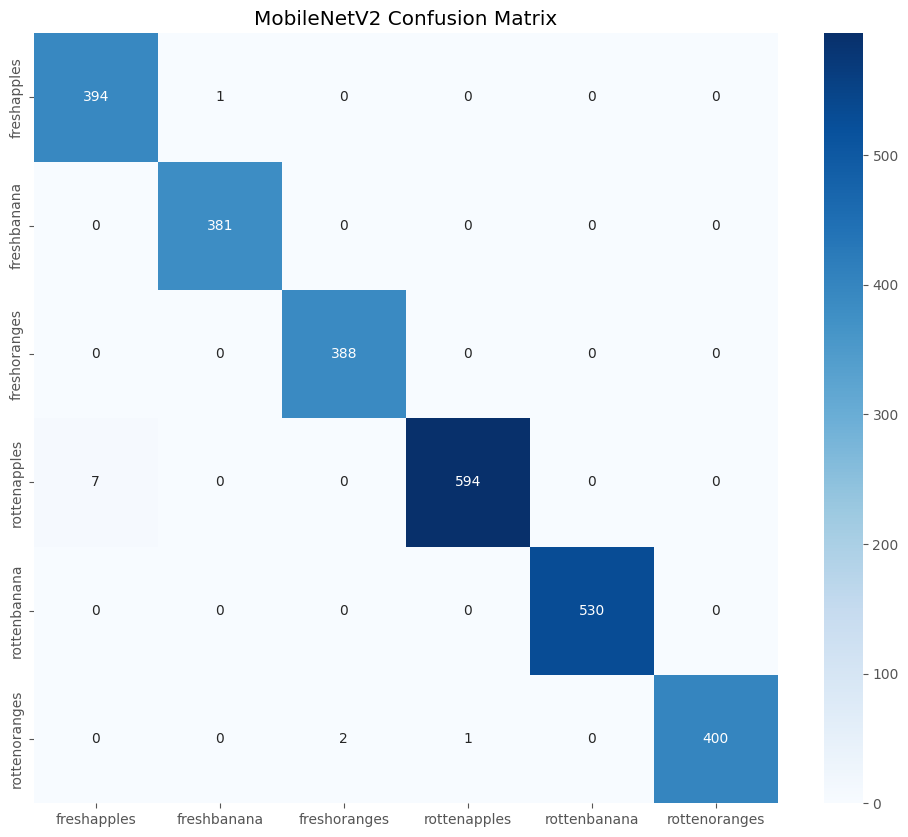

In [12]:
model = load_model('best_model.keras')

y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

print(classification_report(
    y_true,
    y_pred,
    target_names=categories,
    digits=4
))

plt.figure(figsize=(12,10))
sns.heatmap(
    confusion_matrix(y_true, y_pred),
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=categories,
    yticklabels=categories
)
plt.title('MobileNetV2 Confusion Matrix')
plt.show()


In [13]:
def predict_fruit(image_path):
    try:
        model = load_model('best_model.keras')
        img = load_img(image_path, target_size=(224, 224))
        img_array = preprocess_input(img_to_array(img))
        img_array = np.expand_dims(img_array, axis=0)

        preds = model.predict(img_array)
        pred_class = categories[np.argmax(preds)]
        confidence = np.max(preds) * 100

        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {pred_class}\nConfidence: {confidence:.2f}%")
        plt.show()

        return pred_class, round(confidence, 2)
    except Exception as e:
        print(f"Error: {str(e)}")
        return None, None


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


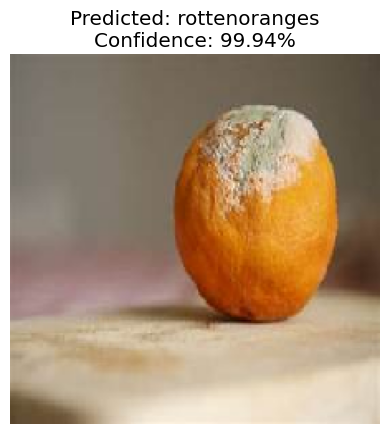

Prediction: rottenoranges (99.94% confidence)


In [14]:
# Replace with your own image
class_name, confidence = predict_fruit("/kaggle/input/rotten/rotten.jpg")
print(f"Prediction: {class_name} ({confidence}% confidence)")


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, concatenate, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

plt.style.use('ggplot')
sns.set_palette("husl")


In [6]:
dataset_path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset'
categories = ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

def create_dataframe(directory):
    image_paths, labels = [], []
    for category in categories:
        category_path = os.path.join(directory, category)
        for img_file in os.listdir(category_path):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(category_path, img_file))
                labels.append(category)
    return pd.DataFrame({'image_path': image_paths, 'category': labels})

train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['category'], random_state=42)


In [7]:
BATCH_SIZE = 64
TARGET_SIZE = (227, 227)

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='image_path', y_col='category',
                                              target_size=TARGET_SIZE, class_mode='sparse',
                                              batch_size=BATCH_SIZE, shuffle=True)
val_gen = val_datagen.flow_from_dataframe(val_df, x_col='image_path', y_col='category',
                                          target_size=TARGET_SIZE, class_mode='sparse',
                                          batch_size=BATCH_SIZE, shuffle=False)


Found 8720 validated image filenames belonging to 6 classes.
Found 2181 validated image filenames belonging to 6 classes.


In [8]:
def fire_module(x, squeeze, expand):
    x = Conv2D(squeeze, (1, 1), activation='relu')(x)
    left = Conv2D(expand, (1, 1), activation='relu')(x)
    right = Conv2D(expand, (3, 3), padding='same', activation='relu')(x)
    return concatenate([left, right])

def build_squeezenet(input_shape=(227, 227, 3), num_classes=6):
    inputs = Input(shape=input_shape)
    x = Conv2D(96, (7, 7), strides=(2, 2), padding='valid', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 16, 64)
    x = fire_module(x, 16, 64)
    x = fire_module(x, 32, 128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 32, 128)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 64, 256)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 64, 256)
    x = Dropout(0.5)(x)
    x = Conv2D(num_classes, (1, 1), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax')(x)

    return Model(inputs, output)

model = build_squeezenet()


In [9]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.2, patience=4, min_lr=1e-7),
    ModelCheckpoint('best_squeezenet.keras', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(train_gen, validation_data=val_gen, epochs=30, callbacks=callbacks, verbose=1)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


137/137 ━━━━━━━━━━━━━━━━━━━━ 140s 867ms/step - accuracy: 0.2064 - loss: 1.7806 - val_accuracy: 0.2114 - val_loss: 1.6871 - learning_rate: 1.0000e-04
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 60s 418ms/step - accuracy: 0.3715 - loss: 1.4937 - val_accuracy: 0.5585 - val_loss: 1.1361 - learning_rate: 1.0000e-04
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 59s 417ms/step - accuracy: 0.6009 - loss: 1.0189 - val_accuracy: 0.6346 - val_loss: 0.9302 - learning_rate: 1.0000e-04
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 59s 414ms/step - accuracy: 0.6474 - loss: 0.9099 - val_accuracy: 0.6859 - val_loss: 0.8058 - learning_rate: 1.0000e-04
Epoch 5/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 59s 413ms/step - accuracy: 0.7118 - loss: 0.7625 - val_accuracy: 0.7309 - val_loss: 0.6843 - learning_rate: 1.0000e-04
Epoch 6/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 59s 415ms/step - accuracy: 0.7262 - loss: 0.7257 - val_accuracy: 0.7588 - val_loss: 0.6375 - learning_rate: 1.0000e-04
Epoch 7/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 59s 415ms/step -

Found 2698 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 794ms/step
               precision    recall  f1-score   support

  freshapples       0.88      0.98      0.93       395
  freshbanana       0.99      0.99      0.99       381
 freshoranges       0.94      0.91      0.93       388
 rottenapples       0.94      0.90      0.92       601
 rottenbanana       0.99      0.96      0.98       530
rottenoranges       0.89      0.91      0.90       403

     accuracy                           0.94      2698
    macro avg       0.94      0.94      0.94      2698
 weighted avg       0.94      0.94      0.94      2698



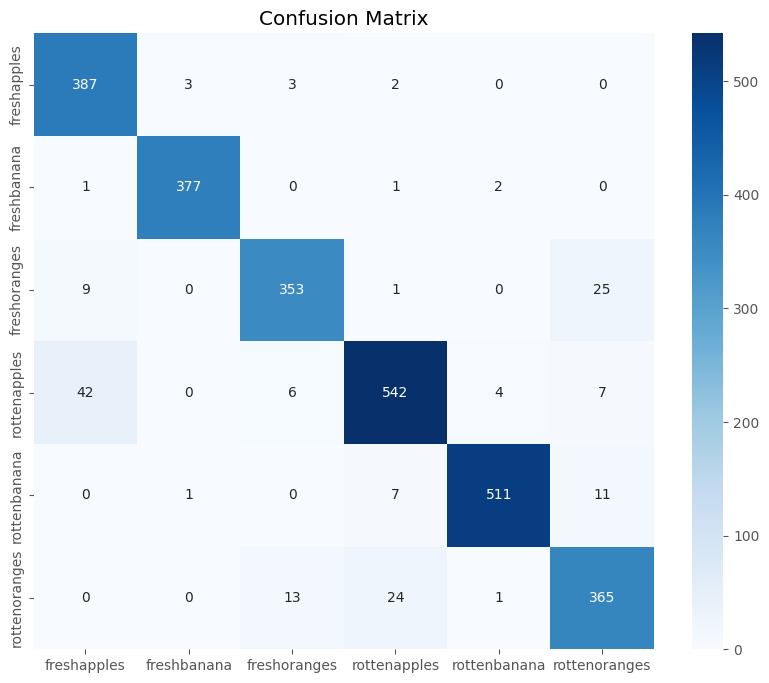

In [10]:
test_gen = test_datagen.flow_from_dataframe(test_df, x_col='image_path', y_col='category',
                                            target_size=TARGET_SIZE, class_mode='sparse',
                                            batch_size=64, shuffle=False)

model = tf.keras.models.load_model('best_squeezenet.keras')

y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

print(classification_report(y_true, y_pred, target_names=categories))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d',
            xticklabels=categories, yticklabels=categories, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


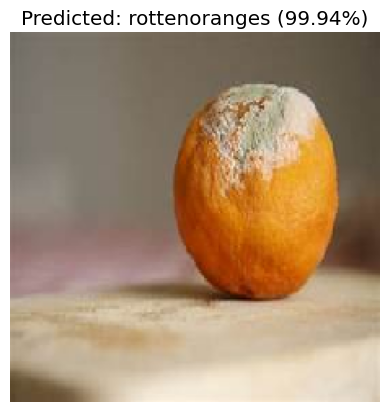

('rottenoranges', 99.94)

In [11]:
def predict_fruit(image_path):
    try:
        img = load_img(image_path, target_size=TARGET_SIZE)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        preds = model.predict(img_array)
        pred_class = categories[np.argmax(preds)]
        confidence = np.max(preds) * 100

        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {pred_class} ({confidence:.2f}%)")
        plt.show()
        
        return pred_class, round(confidence, 2)
    except Exception as e:
        print(f"Error: {e}")
        return None, None

# Example usage
predict_fruit("/kaggle/input/rotten/rotten.jpg")


In [53]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set dataset path and categories
dataset_path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset'
categories = ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']
train_dir = os.path.join(dataset_path, 'train')
test_dir  = os.path.join(dataset_path, 'test')

# Create a DataFrame from a directory
def create_dataframe(directory):
    image_paths, labels = [], []
    for category in categories:
        category_path = os.path.join(directory, category)
        for img_file in os.listdir(category_path):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(category_path, img_file))
                labels.append(category)
    return pd.DataFrame({'image_path': image_paths, 'category': labels})

# Create DataFrames for training and testing
train_df = create_dataframe(train_dir)
test_df  = create_dataframe(test_dir)

# Split training data into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['category'], random_state=42)

# Configure ImageDataGenerators for preprocessing
BATCH_SIZE = 64
TARGET_SIZE = (227, 227)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

# Create generators from the DataFrames
train_gen = train_datagen.flow_from_dataframe(train_df, 
                                              x_col='image_path', 
                                              y_col='category',
                                              target_size=TARGET_SIZE, 
                                              class_mode='sparse',
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True)

val_gen = val_datagen.flow_from_dataframe(val_df, 
                                          x_col='image_path', 
                                          y_col='category',
                                          target_size=TARGET_SIZE, 
                                          class_mode='sparse',
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False)


Found 8720 validated image filenames belonging to 6 classes.
Found 2181 validated image filenames belonging to 6 classes.


In [54]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, GlobalAveragePooling2D, Dropout, Activation, BatchNormalization, MaxPooling2D, Lambda
from tensorflow.keras.models import Model

# Convolution branch used in the shuffle unit
def conv_branch(x, out_channels, stride):
    # 1x1 pointwise convolution
    x = Conv2D(out_channels, (1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # 3x3 depthwise convolution
    x = DepthwiseConv2D(kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    # 1x1 pointwise convolution
    x = Conv2D(out_channels, (1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# Channel shuffle operation wrapped in Lambda
def channel_shuffle(x, groups):
    def shuffle_func(z):
        batch_size = tf.shape(z)[0]
        height     = tf.shape(z)[1]
        width      = tf.shape(z)[2]
        channels   = tf.shape(z)[3]
        group_channels = channels // groups
        # Reshape to (batch_size, height, width, groups, group_channels)
        z = tf.reshape(z, [batch_size, height, width, groups, group_channels])
        # Transpose group and channel dimensions
        z = tf.transpose(z, [0, 1, 2, 4, 3])
        # Flatten back to (batch_size, height, width, channels)
        z = tf.reshape(z, [batch_size, height, width, channels])
        return z
    return Lambda(shuffle_func)(x)

# Shuffle unit: For stride==1, we split channels; for stride != 1, use two branches.
def shuffle_unit(x, out_channels, stride):
    half_channels = out_channels // 2
    if stride == 1:
        # Split along channel axis (assumes input channels == out_channels)
        x1 = Lambda(lambda z: z[..., :tf.cast(tf.shape(z)[-1] // 2, tf.int32)])(x)
        x2 = Lambda(lambda z: z[..., tf.cast(tf.shape(z)[-1] // 2, tf.int32):])(x)
        y1 = x1
        y2 = conv_branch(x2, half_channels, stride)
        out = tf.keras.layers.Concatenate()([y1, y2])
    else:
        y1 = conv_branch(x, half_channels, stride)
        y2 = conv_branch(x, half_channels, stride)
        out = tf.keras.layers.Concatenate()([y1, y2])
    out = channel_shuffle(out, groups=2)
    return out

# Build the complete ShuffleNet model.
def build_shufflenet(input_shape=(227, 227, 3), num_classes=6):
    inputs = Input(shape=input_shape)
    
    # Initial convolution and max-pooling
    x = Conv2D(24, (3, 3), strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # Expand channels to 240 (for stage 1) via a 1x1 convolution
    x = Conv2D(240, (1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Stage 1: 4 shuffle units with stride 1 (channels remain 240)
    for _ in range(4):
        x = shuffle_unit(x, out_channels=240, stride=1)
    # Transition: 1 shuffle unit with stride 2 to double channels to 480
    x = shuffle_unit(x, out_channels=480, stride=2)
    
    # Stage 2: 8 shuffle units with stride 1 (channels remain 480)
    for _ in range(8):
        x = shuffle_unit(x, out_channels=480, stride=1)
    # Transition: 1 shuffle unit with stride 2 to double channels to 960
    x = shuffle_unit(x, out_channels=960, stride=2)
    
    # Stage 3: 4 shuffle units with stride 1 (channels remain 960)
    for _ in range(4):
        x = shuffle_unit(x, out_channels=960, stride=1)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs, outputs)

# Create the model instance
model = build_shufflenet()
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, GlobalAveragePooling2D, Dropout, Activation, BatchNormalization, MaxPooling2D, Lambda
from tensorflow.keras.models import Model

# Convolution branch used in the shuffle unit
def conv_branch(x, out_channels, stride):
    # 1x1 pointwise convolution
    x = Conv2D(out_channels, (1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # 3x3 depthwise convolution
    x = DepthwiseConv2D(kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    # 1x1 pointwise convolution
    x = Conv2D(out_channels, (1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# Channel shuffle operation wrapped in Lambda
def channel_shuffle(x, groups):
    def shuffle_func(z):
        batch_size = tf.shape(z)[0]
        height     = tf.shape(z)[1]
        width      = tf.shape(z)[2]
        channels   = tf.shape(z)[3]
        group_channels = channels // groups
        # Reshape to (batch_size, height, width, groups, group_channels)
        z = tf.reshape(z, [batch_size, height, width, groups, group_channels])
        # Transpose group and channel dimensions
        z = tf.transpose(z, [0, 1, 2, 4, 3])
        # Flatten back to (batch_size, height, width, channels)
        z = tf.reshape(z, [batch_size, height, width, channels])
        return z
    return Lambda(shuffle_func)(x)

# Shuffle unit: For stride==1, we split channels; for stride != 1, use two branches.
def shuffle_unit(x, out_channels, stride):
    half_channels = out_channels // 2
    if stride == 1:
        # Split along channel axis (assumes input channels == out_channels)
        x1 = Lambda(lambda z: z[..., :tf.cast(tf.shape(z)[-1] // 2, tf.int32)])(x)
        x2 = Lambda(lambda z: z[..., tf.cast(tf.shape(z)[-1] // 2, tf.int32):])(x)
        y1 = x1
        y2 = conv_branch(x2, half_channels, stride)
        out = tf.keras.layers.Concatenate()([y1, y2])
    else:
        y1 = conv_branch(x, half_channels, stride)
        y2 = conv_branch(x, half_channels, stride)
        out = tf.keras.layers.Concatenate()([y1, y2])
    out = channel_shuffle(out, groups=2)
    return out

# Build the complete ShuffleNet model.
def build_shufflenet(input_shape=(227, 227, 3), num_classes=6):
    inputs = Input(shape=input_shape)
    
    # Initial convolution and max-pooling
    x = Conv2D(24, (3, 3), strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # Expand channels to 240 (for stage 1) via a 1x1 convolution
    x = Conv2D(240, (1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Stage 1: 4 shuffle units with stride 1 (channels remain 240)
    for _ in range(4):
        x = shuffle_unit(x, out_channels=240, stride=1)
    # Transition: 1 shuffle unit with stride 2 to double channels to 480
    x = shuffle_unit(x, out_channels=480, stride=2)
    
    # Stage 2: 8 shuffle units with stride 1 (channels remain 480)
    for _ in range(8):
        x = shuffle_unit(x, out_channels=480, stride=1)
    # Transition: 1 shuffle unit with stride 2 to double channels to 960
    x = shuffle_unit(x, out_channels=960, stride=2)
    
    # Stage 3: 4 shuffle units with stride 1 (channels remain 960)
    for _ in range(4):
        x = shuffle_unit(x, out_channels=960, stride=1)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs, outputs)

# Create the model instance
model = build_shufflenet()


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set up training callbacks
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.2, patience=4, min_lr=1e-7),
    ModelCheckpoint('best_shufflenet.keras', monitor='val_accuracy', save_best_only=True)
]

# Train the model
history = model.fit(train_gen, validation_data=val_gen, epochs=30, callbacks=callbacks, verbose=1)
uhih

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


137/137 ━━━━━━━━━━━━━━━━━━━━ 150s 677ms/step - accuracy: 0.4195 - loss: 1.4267 - val_accuracy: 0.1463 - val_loss: 1.8020 - learning_rate: 1.0000e-04
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 63s 437ms/step - accuracy: 0.8524 - loss: 0.4196 - val_accuracy: 0.1463 - val_loss: 1.8660 - learning_rate: 1.0000e-04
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 62s 435ms/step - accuracy: 0.9115 - loss: 0.2473 - val_accuracy: 0.1463 - val_loss: 2.4051 - learning_rate: 1.0000e-04
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 63s 441ms/step - accuracy: 0.9340 - loss: 0.1830 - val_accuracy: 0.3865 - val_loss: 4.1315 - learning_rate: 1.0000e-04
Epoch 5/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 63s 442ms/step - accuracy: 0.9575 - loss: 0.1324 - val_accuracy: 0.5823 - val_loss: 1.9270 - learning_rate: 1.0000e-04
Epoch 6/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 63s 440ms/step - accuracy: 0.9690 - loss: 0.0956 - val_accuracy: 0.9532 - val_loss: 0.1379 - learning_rate: 2.0000e-05
Epoch 7/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 62s 438ms/step -